In [1]:
# Elementy Sztucznej Inteligencji
# Informatyka i Ekonometria, IV semestr, WZ, AGH.

# Grupa 3
# "Obliczanie szans na choroby wieńcowe/atak serca"
# Paweł Brodziak
# Magdalena Leśniak
# Marceli Ptak

# Tworzenie sieci neuronowej z użyciem funkcji Sigmoid

In [2]:
import pandas as pd
#from numpy.linalg import norm
from scipy import optimize
from matplotlib.pyplot import *
import numpy as np

In [3]:
#Pobranie danych z pliku Excel
df = pd.read_excel('data_heart_disease.xlsx')

In [4]:
#Podział danych na część uczącą i testową (80:20)
df_learn = df.iloc[:int(0.8*len(df)),:]
df_test = df.iloc[int(0.8*len(df)):,:]

In [5]:
#Zamiana danych na dane wejściowe X i dane docelowe (wyniki) y w formacie numpy
X = np.array([df_learn.HighBP,df_learn.HighChol,df_learn.CholCheck,df_learn.BMI,df_learn.Smoker,df_learn.Stroke,df_learn.Diabetes,df_learn.PhysActivity,df_learn.Fruits,df_learn.Veggies,df_learn.HvyAlcoholConsump,df_learn.DiffWalk,df_learn.Sex,df_learn.Age]).transpose()

df_learn_y = pd.DataFrame(df_learn.HeartDiseaseorAttack)
y = np.array(df_learn_y)

X = X/np.amax(X, axis=0)

In [6]:
#Zamiana danych na format numpy dla X i y testowych
test_X = np.array([df_test.HighBP,df_test.HighChol,df_test.CholCheck,df_test.BMI,df_test.Smoker,df_test.Stroke,df_test.Diabetes,df_test.PhysActivity,df_test.Fruits,df_test.Veggies,df_test.HvyAlcoholConsump,df_test.DiffWalk,df_test.Sex,df_test.Age]).transpose()

df_test_y = pd.DataFrame(df_test.HeartDiseaseorAttack)
test_y = np.array(df_test_y)

test_X = test_X/np.amax(test_X, axis=0)

In [7]:
#Stworzenie klasy sieci neuronowej
class Neural_Network(object):
    def __init__(self, Lambda=0):
        #Definiowanie globalnych parametró sieci
        self.inputLayerSize = 14
        self.outputLayerSize = 1
        self.firstHiddenLayerSize = 6
        self.secondHiddenLayer2Size = 6

        #Wagi (parametry)
        self.W1 = np.random.randn(self.inputLayerSize, self.firstHiddenLayerSize)
        self.W2 = np.random.randn(self.firstHiddenLayerSize, self.secondHiddenLayer2Size)
        self.W3 = np.random.randn(self.secondHiddenLayer2Size, self.outputLayerSize)

        #Parametr regularyzujący Lambda
        self.Lambda = Lambda

    def propagate(self, X):
        #Funkcja podająca dane do sieci
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        self.a3 = self.sigmoid(self.z3)
        self.z4 = np.dot(self.a3, self.W3)
        y_hat = self.sigmoid(self.z4)
        return y_hat

    def sigmoid(self, z):
        #Zastosowuje funkcję aktywacyjną Sigmoid
        return 1/(1+np.exp(-z))

    def sigmoidPrime(self,z):
        #Pochodna funkcji Sigmoid - oblicz gradient funkcji
        return np.exp(-z)/((1+np.exp(-z))**2)

    def costFunction(self, X, y):
        #Oblicza koszt J dla podanych X,y korzystając z wag zapisanych w klasie.
        self.y_hat = self.propagate(X)
        J = 0.5*sum((y-self.y_hat)**2)/X.shape[0] + (self.Lambda/2)*(np.sum(self.W1**2)+np.sum(self.W2**2)+np.sum(self.W3**2))
        return J

    def costFunctionPrime(self, X, y):
        #Oblicza pochodną dla X oraz y uwzględniając wagi zapisane w klasie
        self.y_hat = self.propagate(X)

        delta4 = np.multiply(-(y-self.y_hat), self.sigmoidPrime(self.z4))
        #Add gradient of regularization term:
        dJW3 = np.dot(self.a3.T, delta4)/X.shape[0] + self.Lambda*self.W3

        delta3 = np.dot(delta4, self.W3.T)*self.sigmoidPrime(self.z3)
        dJW2 = np.dot(self.a2.T, delta3)/X.shape[0] + self.Lambda*self.W2

        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJW1 = np.dot(X.T, delta2)/X.shape[0] + self.Lambda*self.W1

        return dJW1, dJW2, dJW3

     #Funkcje pomocnicze do interakcji z innymi metodami oraz klasami - klasa treningu:
    def getParams(self):
        #Pobiera wagi W1, W2, W3 zamienione w wektory
        params = np.concatenate((self.W1.ravel(), self.W2.ravel(), self.W3.ravel()))
        return params

    def setParams(self, params):
        #Ustawia wagi W1, W2, W3 używając wektorów
        W1_start = 0
        W1_end = self.firstHiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.firstHiddenLayerSize))
        W2_end = W1_end + self.firstHiddenLayerSize*self.secondHiddenLayer2Size
        self.W2 = np.reshape(params[W1_end:W2_end], (self.firstHiddenLayerSize, self.secondHiddenLayer2Size))
        W3_end = W2_end + self.secondHiddenLayer2Size*self.outputLayerSize
        self.W3 = np.reshape(params[W2_end:W3_end], (self.secondHiddenLayer2Size, self.outputLayerSize))

    def computeGradients(self, X, y):
        #Oblicz gradient funkcji od X i y
        dJdW1, dJdW2, dJdW3 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel(), dJdW3.ravel()))

In [8]:
#Stworzenie klasy trenującej sieć
class trener(object):
    def __init__(self, N):
        #Stworzenie lokalnych odniesień do sieci
        self.N = N

    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))
        self.testJ.append(self.N.costFunction(self.testX, self.testY))

    def costFunctionWrapper(self, params, X, y):
        #Obliczanie kosztów oraz gradientu funkcji dla podanych parametrów X oraz y
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)

        return cost, grad

    def train(self, trainX, trainY, testX, testY):
        #Tworzenie lokalnych zmiennych używanych przez funkcje klasy
        self.X = trainX
        self.y = trainY

        self.testX = testX
        self.testY = testY

        #Stworzenie pustych list aby zapisywać koszty obliczane przez każdą iterację
        self.J = []
        self.testJ = []

        params0 = self.N.getParams()

        #Optymalizacja - szukanie najniższego kosztu w sieci
        options = {'maxiter':1000, 'disp' : True}
        result = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS',
                                 args=(trainX, trainY), options=options, callback=self.callbackF)

        self.N.setParams(result.x)
        self.optimizationResults = result


In [9]:
NN = Neural_Network(Lambda = 0.0001 )

In [10]:
T = trener(NN)

In [11]:
T.train(X,y, test_X, test_y)

Optimization terminated successfully.
         Current function value: 0.038717
         Iterations: 203
         Function evaluations: 217
         Gradient evaluations: 217


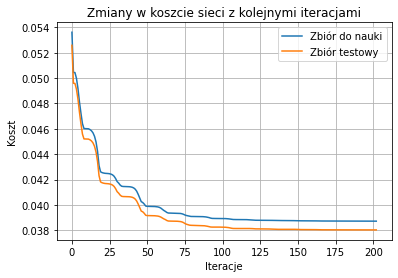

In [12]:
plot(T.J, label='Zbiór do nauki')
plot(T.testJ, label='Zbiór testowy')
grid(1)
title('Zmiany w koszcie sieci z kolejnymi iteracjami')
xlabel('Iteracje')
ylabel('Koszt')
legend()
show()

In [13]:
NN.propagate(test_X)

array([[0.03050506],
       [0.47716467],
       [0.25313494],
       ...,
       [0.01592294],
       [0.08192398],
       [0.14035139]])

In [14]:
test_y

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]])

In [17]:
test = np.array([0,1,1,32,1,1,0,0,0,0,1,1,1,45])
NN.propagate(test)

array([0.69392465])